In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
def pickle_desc(info, path):
    filehandler = open(path,"wb")
    pickle.dump(info, filehandler)
    filehandler.close()
    
def unpickle_desc(path):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def sift_img(img):
    sift = cv2.ORB_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def get_matches(des1, des2):
    # FLANN parameters
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 2) #2
    search_params = {}   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    try:
        matches = flann.knnMatch(des1,des2,k=2)
    except:
        return 0, 0
    
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    
    # ratio test as per Lowe's paper
    for i, tup in enumerate(matches):
        try:
            m, n = tup
            if m.distance < 0.75*n.distance:
                matchesMask[i]=[1,0]
        except:
            continue
    
    return matches, matchesMask

def show_matches(img1, img2, kp1, kp2, matches, matchesMask):
    
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    
    plt.figure(figsize=(20,20))
    plt.imshow(img3),plt.show()

def FSCS(img, K, A, B):
    P = (K - 1) / (B - A)
    L = -A * P
    img_j = (P * img + L)
    print(np.min(img_j), np.max(img_j))
    img_j[img_j < 0] = 0 # do not let negative numbers wrap around
    img_j[img_j > 255] = 255 # do not let overflow wrap around
    return img_j.astype(np.uint8)

In [116]:
ob_name = 'gap2'

# read in the obstacle, binarize, and crop

obstacle = cv2.imread('./SIFT_Images/img1309.png')
# obstacle[obstacle > 50] = 255
# obstacle[obstacle <= 50] = 0
obstacle = obstacle[75:175, 150:350]

# sift the obstacle and pickle the description

kob, ob_desc = sift_img(obstacle)
cv2.imwrite('./Obstacles/Temple/' + ob_name + '-ORB.png', obstacle)
pickle_desc(ob_desc, './Obstacles/Temple/ORB/' + ob_name + '.pickle')

In [117]:
# read in the obstacle

obstacle = cv2.imread('./Obstacles/Temple/' + ob_name + '.png')


# get obstacle description

ob_desc = unpickle_desc('./Obstacles/Temple/ORB/' + ob_name + '.pickle')

In [120]:
# read in the frame, binarize, and crop

frame = cv2.imread('./SIFT_Images/img1307.png')
# frame[frame > 50] = 255
# frame[frame <= 50] = 0
frame = frame[75:175, 150:350]

# sift the frame

kf, frame_desc = sift_img(frame)

72


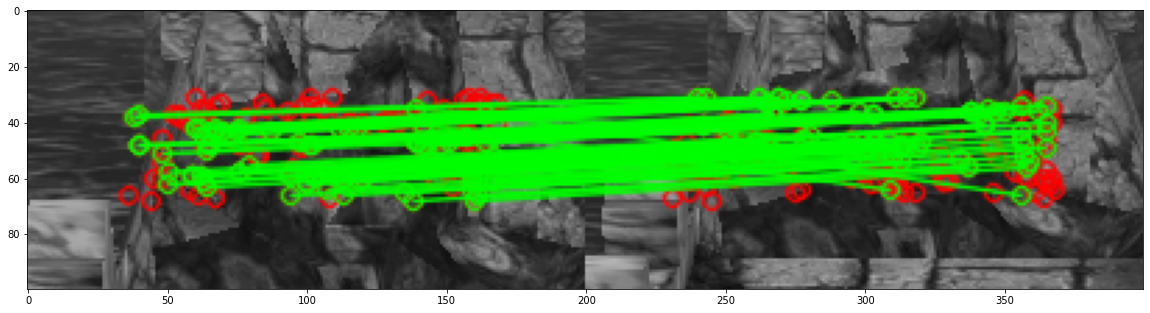

In [121]:
matches, matchesMask = get_matches(ob_desc, frame_desc)
print(np.sum(matchesMask))
show_matches(obstacle, frame, kob, kf, matches, matchesMask)